<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 - AutoEncoder
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [58]:
# Set your student number
student_number = 98100118
Name = 'parham'
Last_Name = 'chavoshian'

# Rules
- You **are** allowed to add or remove cells.
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [ ]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q3.ipynb")
with open(f'python_code_Q3_{student_number}.py', 'w') as file:
    file.write(python_code)

# Autoencoders (25 Points Extra)

<font size=4>
Author: Ahmad Salimi
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this problem, you should implement an autoencoder network, which generates an image presenting the next digit of the input digit. Here are some examples:

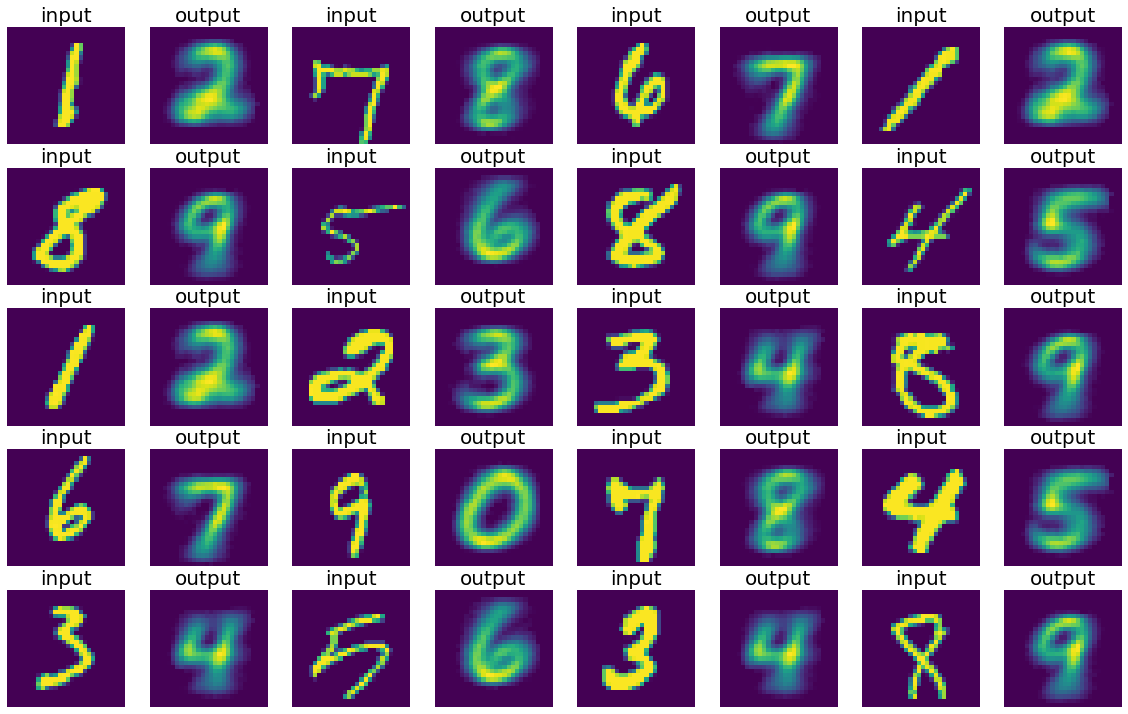

You should use the MNIST dataset, and the ground-truth for each example is provided by a helper function. Make sure to put the `ae_helper.py` file next to this notebook to use the helper function.

## Get the data

Get the data and split them into training, validation, and test sets, by running the following cell. `X` is the input images, `Y` is the ground-truth for each input, and `y` is the input's label.

In [56]:
from Helper_codes.ae_helper import get_data
from sklearn.model_selection import train_test_split

X, Y, y = get_data()

X_train, X_test, Y_train, Y_test, y_train, y_test = train_test_split(X, Y, y, test_size=0.2, random_state=17)
X_train, X_val, Y_train, Y_val, y_train, y_val = train_test_split(X_train, Y_train, y_train, test_size=0.1, random_state=17)

## Design your model

Please Implement your autoencoder model below. You MUST implement your model using the `torch` package. The model should input a batch of images and output the generated images for the whole batch. Your model can be consist of fully connected layers (using linear layers), but using fully-convolutional models has extra points.

In [2]:
from typing import Tuple

import os
import math
import random
import copy
import glob
import time
from imutils import paths

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import gzip
import cv2
import skimage
import skimage.transform
from tqdm import tqdm

from PIL import Image

In [3]:
class Block(nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=2)
    self.conv2 = nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=2)
    self.bn1 = nn.BatchNorm2d(num_features=in_ch)
    self.bn2 = nn.BatchNorm2d(num_features=out_ch)
    self.relu  = nn.ReLU()
    
  def forward(self, x):
    x = self.bn1(x)
    x = self.conv1(x)
    x = self.relu(x)
    x = self.bn2(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

In [4]:
class Encoder(nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.enc_blocks = nn.ModuleList([Block(channels[i - 1], channels[i]) for i in range(1, len(channels))])
    self.pool = nn.MaxPool2d(2)
    
  def forward(self, x):
    ftrs = []
    for block in self.enc_blocks:
      x = block(x)
      ftrs.append(x)
      x = self.pool(x)
    return ftrs

In [5]:
class Decoder(nn.Module):
  def __init__(self, chs):
    super().__init__()
    self.chs = chs
    self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_channels=chs[i - 1], out_channels=chs[i], kernel_size=2, stride=2) for i in range(1, len(chs))])
    self.dec_blocks = nn.ModuleList([Block(chs[i - 1], chs[i]) for i in range(1, len(chs))]) 
        
  def forward(self, x, encoder_features):
    for i in range(len(self.chs)-1):
      x = self.upconvs[i](x)
      enc_ftr = self.crop(encoder_features[i], x)
      x = torch.cat([x, enc_ftr], dim=1)
      x = self.dec_blocks[i](x)
    return x
    
  def crop(self, enc_ftr, x):
    _, _, H, W = x.shape
    enc_ftr = torchvision.transforms.CenterCrop([H, W])(enc_ftr)
    return enc_ftr

In [6]:
#### IMPLEMENT YOUR MODEL ####
class Model(nn.Module):
  def __init__(self, enc_chs=(1,32,64,128), dec_chs=(128, 64, 32), fin_channel=1, retain_dim=True, out_sz=(28,28)):
    super().__init__()
    self.encoder = Encoder(enc_chs)
    self.decoder = Decoder(dec_chs)
    self.head = nn.Conv2d(in_channels=dec_chs[-1], out_channels=fin_channel, kernel_size=1)
    self.retain_dim = retain_dim
    self.out_sz = out_sz

  def forward(self, x):
    enc_ftrs = self.encoder(x)
    out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
    out = self.head(out)
    if self.retain_dim:
      out = functional.interpolate(out, self.out_sz)
    return out


## The dataset class, and the dataloaders

The following cells implement the dataset class and create the data loaders for training and validation sets. Feel free to modify the batch size for each data loader.

In [7]:
class MnistNextDigitDataset(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(np.expand_dims(X, axis=1))
        self.Y = torch.from_numpy(np.expand_dims(Y, axis=1))
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return self.X.shape[0]

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, ...]:
        return self.X[i], self.Y[i], self.y[i]

In [8]:
# Hyperparameters
train_batch_size = 32
val_batch_size = 16
test_batch_size = 16
lr = 0.0095
momentum = 0.9
weight_decay = 0.001
gamma = 0.995
epochs = 20

In [9]:
train_dataloader = DataLoader(
    MnistNextDigitDataset(X_train, Y_train, y_train),
    batch_size=train_batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    MnistNextDigitDataset(X_val, Y_val, y_val),
    batch_size=val_batch_size,
    shuffle=False
)
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}

## Instantiate the model and optimizer

Instantiate your model and optimizer in the following cell. Feel free to choose the optimizer and its configurations such as learning rate, decay, etc.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
#### INSTANTIATE YOUR MODEL AND OPTIMIZER ####
model = Model().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

## Train your autoencoder

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). Make sure to use proper and readable logging containing training and validation metrics for each epoch. Select and store the state dictionary of the best epoch model according to the metrics.

In [12]:
#### IMPLEMENT YOUR TRAIN/VAL LOOP ####
def train_model(model, datalaoders, optimizer, criterion, scheduler, load_model=False, model_name='correct_rotation'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    history = {'train': [], 'val': []}

    if load_model:
        model.load_state_dict(torch.load(model_name + '_best.pth.tar'))
    
    for epoch in range(epochs):
        print('\n\nEpoch {}/{}'.format(epoch + 1, epochs))
        print('-' * 10)
        
        since = time.time()
        
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                model.train()
            else:
                model.eval()

            epoch_loss = 0
            for inputs, truth, labels in datalaoders[phase]:
                inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
                truth = truth.to("cuda" if torch.cuda.is_available() else "cpu")

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, truth)
                    epoch_loss += loss.item()
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
            epoch_loss /= (len(datalaoders[phase].dataset) / eval(phase + '_batch_size'))
            print(phase + " loss: {:4f}".format(epoch_loss))
            history[phase].append(epoch_loss)

            if phase == 'train':
                scheduler.step()
            
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'epoch': epoch + 1, 
                            'model': model.state_dict(), 
                            'optimizer' : optimizer.state_dict(),
                            'scheduler' : scheduler.state_dict()},
                             model_name + '_best.pth.tar'.format(epoch + 1))
            
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        
    print('Best Val Loss: {:4f}'.format(best_loss))
    
    model.load_state_dict(best_model_wts)
    
    return model, history

In [13]:
model, history = train_model(model, dataloaders, optimizer, criterion, scheduler, False, 'MNIST_next_vol1')



Epoch 1/20
----------
LR 0.0095
train loss: 0.063491
val loss: 0.057484
saving best model
2m 33s


Epoch 2/20
----------
LR 0.009452499999999999
train loss: 0.056915
val loss: 0.056607
saving best model
2m 33s


Epoch 3/20
----------
LR 0.009405237499999998
train loss: 0.056171
val loss: 0.055934
saving best model
2m 33s


Epoch 4/20
----------
LR 0.009358211312499998
train loss: 0.055812
val loss: 0.055782
saving best model
2m 33s


Epoch 5/20
----------
LR 0.009311420255937498
train loss: 0.055541
val loss: 0.055591
saving best model
2m 33s


Epoch 6/20
----------
LR 0.00926486315465781
train loss: 0.055349
val loss: 0.055606
2m 33s


Epoch 7/20
----------
LR 0.009218538838884521
train loss: 0.055199
val loss: 0.055713
2m 33s


Epoch 8/20
----------
LR 0.009172446144690097
train loss: 0.055061
val loss: 0.055343
saving best model
2m 33s


Epoch 9/20
----------
LR 0.009126583913966648
train loss: 0.054914
val loss: 0.055157
saving best model
2m 33s


Epoch 10/20
----------
LR 0.0090

## Load the state dictionary of the best epoch

Load the state dictionary of the best epoch model into the model object.

In [33]:
#### LOAD THE BEST EPOCH STATE DICTIONARY ####
best_model = Model().to(device)
best_model.load_state_dict(torch.load('MNIST_next_vol1_best.pth.tar')['model'])

<All keys matched successfully>

## Visualize your model

Select 40 examples from the test set and visualize the input and output of the model for them (See the examples at the beginning of the notebook).

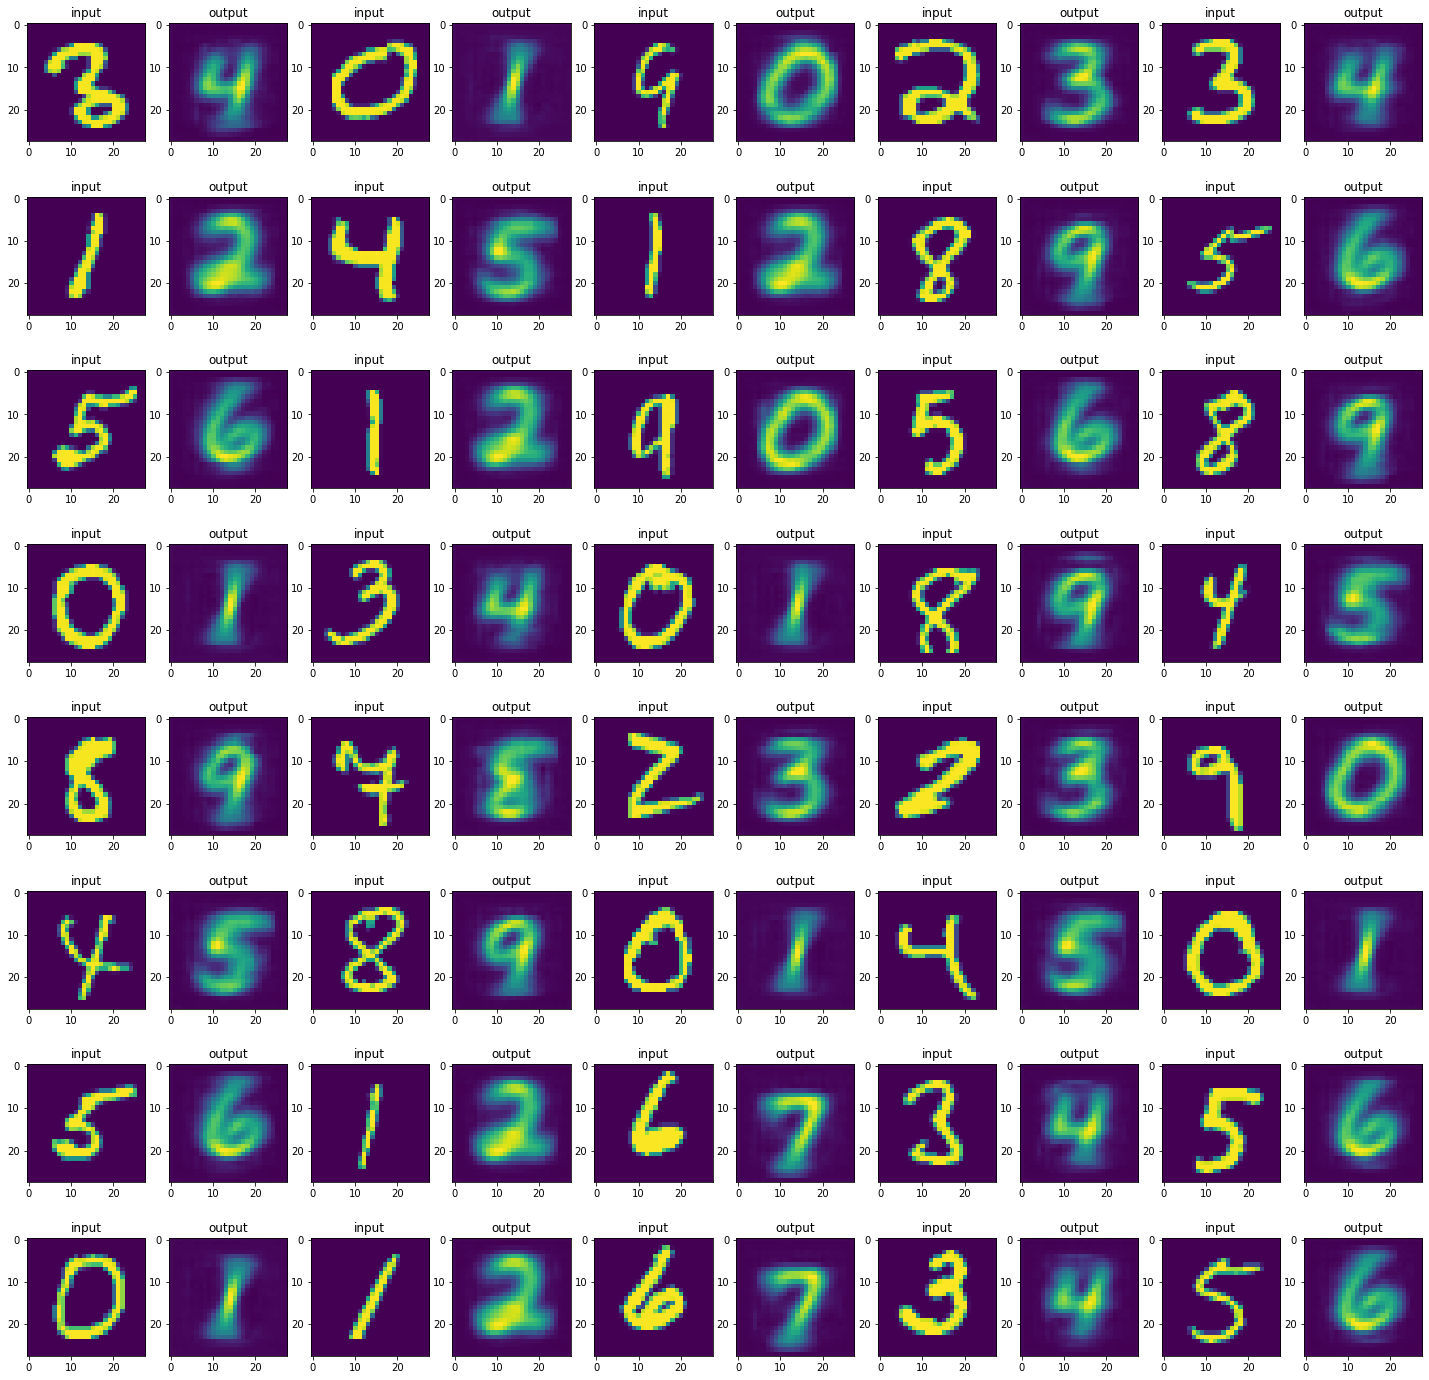

In [54]:
#### VISUALIZE YOUR MODEL ####
fig, axs = plt.subplots(8, 10, figsize=(25, 25))
for i in range(8):
  for j in range(0, 10, 2):
    index = np.random.randint(0, X_test.shape[0])
    main_img = X_train[index, :, :]
    tens_img = torch.from_numpy(main_img).reshape((1, 1, 28, 28)).to(device)
    res = model(tens_img)
    pred_img = res.detach().cpu().numpy().reshape((28, 28))
    axs[i][j].imshow(main_img)
    axs[i][j].set_title('input')
    axs[i][j + 1].imshow(pred_img)
    axs[i][j + 1].set_title('output')